In [239]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [240]:
data = pd.read_csv('./UNRATE.csv', names=['date', 'unrate'])
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
data = data.set_index('date')
data.head()

,unrate
date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 867 entries, 1948-01-01 to 2020-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unrate  867 non-null    float64
dtypes: float64(1)
memory usage: 13.5 KB


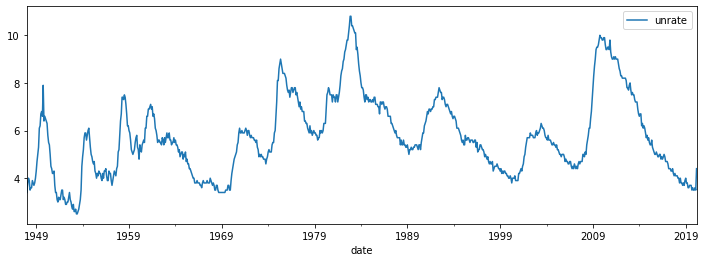

In [242]:
data.plot(figsize=(12, 4))
plt.show(block=False)

In [243]:
data.shape

(867, 1)

### Q1: Perform Boxcox transformation with `lambda = 0` and one lag differencing

- 1. Boxcox transformation to make variance constant

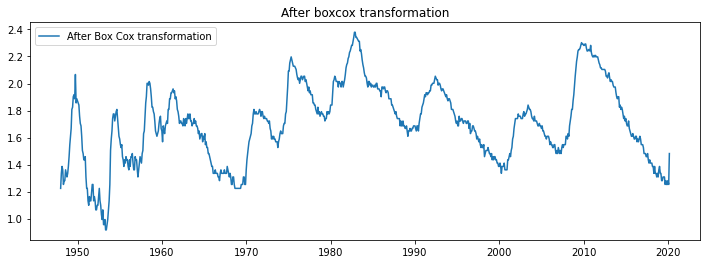

In [244]:
data_boxcox = pd.Series(boxcox(data['unrate'], lmbda=0), index=data.index)

plt.figure(figsize=(12, 4))
plt.plot(data_boxcox, label='After Box Cox transformation')
plt.legend(loc='best')
plt.title('After boxcox transformation')
plt.show()

In [245]:
data_boxcox.shape

(867,)

- 2. Differencing with one lag to remove trend

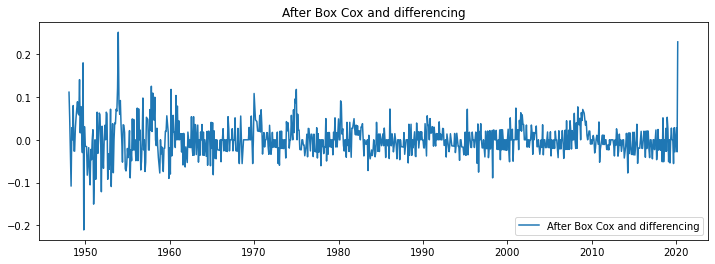

In [246]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12, 4))
plt.plot(data_boxcox_diff, label='After Box Cox and differencing')
plt.legend(loc='best')
plt.title('After Box Cox and differencing')
plt.show()

In [247]:
data_boxcox_diff.shape

(867,)

In [248]:
# Replacing nans
data_boxcox_diff.dropna(inplace=True)

### Augmented Dickey-Fuller (ADF) test

In [249]:
adf_test = adfuller(data_boxcox_diff)
print('ADF Statistics: %.2f' % adf_test[0])
print('Critical values @0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistics: -8.92
Critical values @0.05: -2.86
p-value: 0.000000


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [250]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Stats: %.2f' % kpss_test[0])
print('KPSS Critical value @0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Stats: 0.06
KPSS Critical value @0.05: 0.46
p-value: 0.100000


With above both tests, we conclude that the data is stationary now

### Autocorrelation Function (ACF)

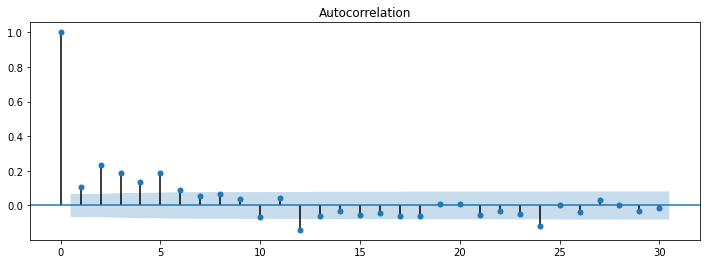

In [251]:
plt.figure(figsize=(12, 4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

### Partial Autocorrelation Function (PACF)

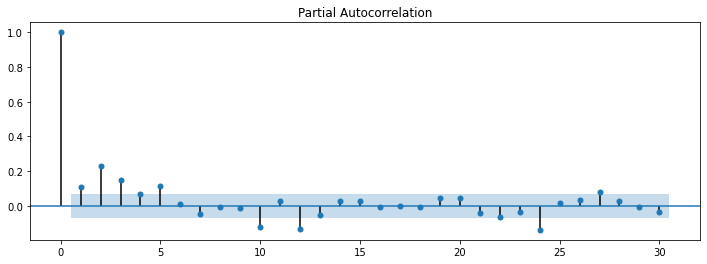

In [252]:
plt.figure(figsize=(12, 4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [253]:
train_len = 612
train = data[:train_len]
test = data[train_len:]

train.shape, test.shape

((612, 1), (255, 1))

In [254]:
train_boxcox = data_boxcox[:train_len]
test_boxcox = data_boxcox[train_len:]

train_boxcox_diff = data_boxcox_diff[:train_len]
test_boxcox_diff = data_boxcox_diff[train_len:]

### Auto regression (AR) model 

In [255]:
model = ARIMA(train_boxcox_diff, order=(12,0,0))
model_fit = model.fit()
print(model_fit.params)

const     0.000416
ar.L1     0.060731
ar.L2     0.161929
ar.L3     0.119166
ar.L4     0.089828
ar.L5     0.106976
ar.L6     0.008244
ar.L7    -0.030011
ar.L8     0.031954
ar.L9     0.008187
ar.L10   -0.125191
ar.L11    0.046802
ar.L12   -0.148053
sigma2    0.001472
dtype: float64


### Predicting & Recovering original time series

In [256]:
y_pred_boxcox_diff = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_pred_boxcox = y_pred_boxcox_diff.cumsum()
y_pred_boxcox = y_pred_boxcox.add(data_boxcox[0])
y_pred = np.exp(y_pred_boxcox)

In [257]:
y_pred[test.index.min():]

1999-01-01    5.023531
1999-02-01    5.072138
1999-03-01    4.986195
1999-04-01    5.017441
1999-05-01    4.996401
                ...   
2019-11-01    5.549484
2019-12-01    5.551792
2020-01-01    5.554101
2020-02-01    5.556412
2020-03-01    5.558723
Freq: MS, Length: 255, dtype: float64

In [258]:
y_pred.shape, data_boxcox_diff.shape, data.shape

((866,), (866,), (867, 1))

### Plot train, test and forecast

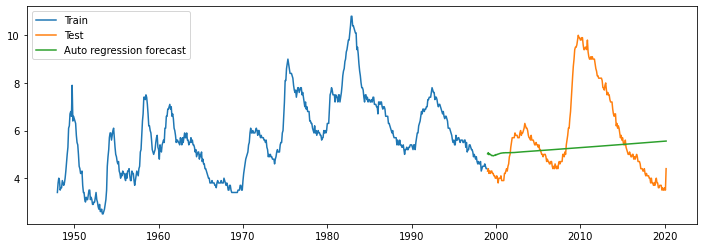

In [259]:
plt.figure(figsize=(12, 4))
plt.plot(train['unrate'], label='Train')
plt.plot(test['unrate'], label='Test')
plt.plot(y_pred[test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.show()

### Calculate RMSE and MAPE

In [260]:
rmse = np.sqrt(mean_squared_error(test['unrate'], y_pred[test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['unrate'] - y_pred[test.index.min():])/test['unrate'])*100, 2)

rmse, mape

(1.87, 22.58)

In [261]:
# Prediction for June 1948
y_pred['1948-06-01'].round(2)

4.21

### Moving Average (MA) Model

In [262]:
ma_model = ARIMA(train_boxcox_diff, order=(0,0,5))
ma_model_fit = ma_model.fit()
print(ma_model_fit.params)

const     0.000460
ma.L1     0.055408
ma.L2     0.182709
ma.L3     0.124264
ma.L4     0.099230
ma.L5     0.151900
sigma2    0.001556
dtype: float64


In [263]:
y_pred_boxcox_diff_ma = ma_model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_pred_boxcox_ma = y_pred_boxcox_diff_ma.cumsum()
y_pred_boxcox_ma = y_pred_boxcox_ma.add(data_boxcox[0])
y_pred_ma = np.exp(y_pred_boxcox_ma)

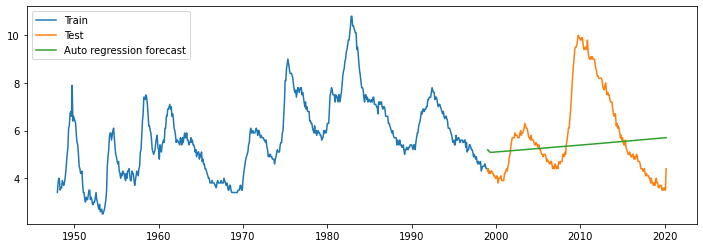

In [264]:
plt.figure(figsize=(12, 4))
plt.plot(train['unrate'], label='Train')
plt.plot(test['unrate'], label='Test')
plt.plot(y_pred_ma[test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.show()

In [265]:
rmse_ma = mean_squared_error(test['unrate'], y_pred_ma[test.index.min():]).round(2)
mape_ma = np.round(np.mean(np.abs(test['unrate'] - y_pred_ma[test.index.min():])/test['unrate'])*100, 2)

rmse_ma, mape_ma

(3.42, 23.19)

In [266]:
# Predicting
y_pred['1948-06-01'].round(2)

4.21

### ARIMA

In [267]:
arima_model = ARIMA(train_boxcox, order=(12, 1, 5))
arima_model_fit = arima_model.fit()
print(arima_model_fit.params)

ar.L1    -0.096897
ar.L2     0.287333
ar.L3     0.441226
ar.L4    -0.091511
ar.L5    -0.169669
ar.L6     0.014303
ar.L7    -0.003100
ar.L8     0.048096
ar.L9     0.058770
ar.L10   -0.097372
ar.L11    0.000950
ar.L12   -0.126221
ma.L1     0.149988
ma.L2    -0.115932
ma.L3    -0.308430
ma.L4     0.177935
ma.L5     0.245505
sigma2    0.001473
dtype: float64


In [271]:
y_pred_boxcox_diff_arima = arima_model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_pred_boxcox_arima = y_pred_boxcox_diff_arima.cumsum()
y_pred_boxcox_arima = y_pred_boxcox_arima.add(data_boxcox[0])
y_pred_arima = np.exp(y_pred_boxcox_arima)

In [273]:
y_pred_arima[test.index.min():]

1999-01-01    inf
1999-02-01    inf
1999-03-01    inf
1999-04-01    inf
1999-05-01    inf
             ... 
2019-11-01    inf
2019-12-01    inf
2020-01-01    inf
2020-02-01    inf
2020-03-01    inf
Freq: MS, Length: 255, dtype: float64

In [274]:
rmse_arima = mean_squared_error(test['unrate'], y_pred_arima[test.index.min():]).round(2)
mape_arima = np.round(np.mean(np.abs(test['unrate'] - y_pred_arima[test.index.min():])/test['unrate'])*100, 2)

rmse_arima, mape_arima

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [270]:
sarima_model = ARIMA(train_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12))
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.params)

ar.L1       0.600363
ar.L2       0.117442
ma.L1      -0.563666
ma.L2       0.000103
ma.L3       0.067861
ma.L4       0.054906
ar.S.L12   -0.934836
ar.S.L24   -0.511162
ma.S.L12   -0.279256
ma.S.L24   -0.537026
ma.S.L36   -0.399248
ma.S.L48    0.269448
sigma2      0.001493
dtype: float64


In [275]:
y_pred_boxcox_diff_sarima = sarima_model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_pred_boxcox_sarima = y_pred_boxcox_diff_sarima.cumsum()
y_pred_boxcox_sarima = y_pred_boxcox_sarima.add(data_boxcox[0])
y_pred_sarima = np.exp(y_pred_boxcox_sarima)

In [276]:
rmse_sarima = mean_squared_error(test['unrate'], y_pred_sarima[test.index.min():]).round(2)
mape_sarima = np.round(np.mean(np.abs(test['unrate'] - y_pred_sarima[test.index.min():])/test['unrate'])*100, 2)

rmse_sarima, mape_sarima

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').